In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files
df1 = pd.read_csv('office_group_records_07_02.csv')
df2 = pd.read_csv('office_actuator_records.csv')

#original_df = df1.copy() #Keep a copy to compare
## Toggle the values of Light Sensor.
df1.loc[df1['sensor_name'] == 'Light Sensor', 'state'] = 1 - df1['state']

# # Find rows where 'state' has changed
# changed_rows = df1[df1['state'] != original_df['state']]

# # Display only the changed rows
# print(changed_rows)

#filter the motion sensor data
filtered_df1 = df1[df1['sensor_name'] != 'Motion Sensor']
print(filtered_df1)
# Combine the two DataFrames (concatenating rows)
combined_office_data = pd.concat([filtered_df1, df2], ignore_index=True)

# Convert the 'datetime' column to a datetime data type if necessary
combined_office_data['datetime'] = pd.to_datetime(combined_office_data['seconds'], unit='s')
# combined_office_data['datetime'] = pd.to_datetime(combined_office_data['date'] + ' ' + combined_office_data['time'], format='%d/%m/%y %H:%M')

# Sort by the 'datetime' column
combined_office_data = combined_office_data.sort_values(by='datetime')

# Display the sorted, combined DataFrame
print(combined_office_data.head)


             date   time       seconds  state         sensor_name  \
514    2024-07-02  08:42  1.719928e+09    1.0         Door Sensor   
521    2024-07-02  08:43  1.719928e+09    0.0         Door Sensor   
532    2024-07-02  08:56  1.719929e+09    1.0         Door Sensor   
535    2024-07-02  08:56  1.719929e+09    1.0  Desk Motion Sensor   
536    2024-07-02  08:56  1.719929e+09    0.0  Desk Motion Sensor   
...           ...    ...           ...    ...                 ...   
35323  2024-10-01  14:34  1.727811e+09    1.0         Door Sensor   
35332  2024-10-01  14:34  1.727811e+09    0.0         Door Sensor   
35344  2024-10-01  14:36  1.727811e+09    1.0         Door Sensor   
35364  2024-10-01  14:43  1.727812e+09    1.0        Light Sensor   
35367  2024-10-01  14:43  1.727812e+09    0.0         Door Sensor   

         thing_name       thing_ip  
514    OfficeMainPi  192.168.86.93  
521    OfficeMainPi  192.168.86.93  
532    OfficeMainPi  192.168.86.93  
535    OfficeMainPi  19

In [96]:
combined_office_data = combined_office_data.set_index('datetime') #make the date column as index
office_hourly = combined_office_data.state.resample('4h').sum() #resample on hourly basis and get summary of sensor values on that hour.

office_hourly = office_hourly.reset_index()
print(office_hourly.head)

<bound method NDFrame.head of                datetime  state
0   2024-07-02 12:00:00   72.0
1   2024-07-02 16:00:00  187.0
2   2024-07-02 20:00:00    0.0
3   2024-07-03 00:00:00    0.0
4   2024-07-03 04:00:00    0.0
..                  ...    ...
543 2024-10-01 00:00:00    0.0
544 2024-10-01 04:00:00    0.0
545 2024-10-01 08:00:00    0.0
546 2024-10-01 12:00:00    2.0
547 2024-10-01 16:00:00   22.0

[548 rows x 2 columns]>


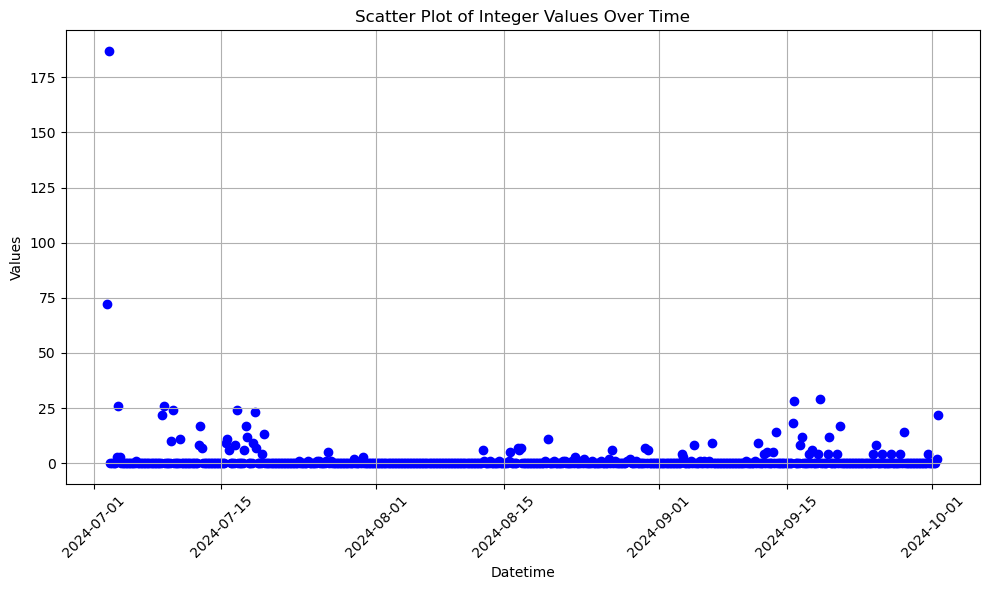

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

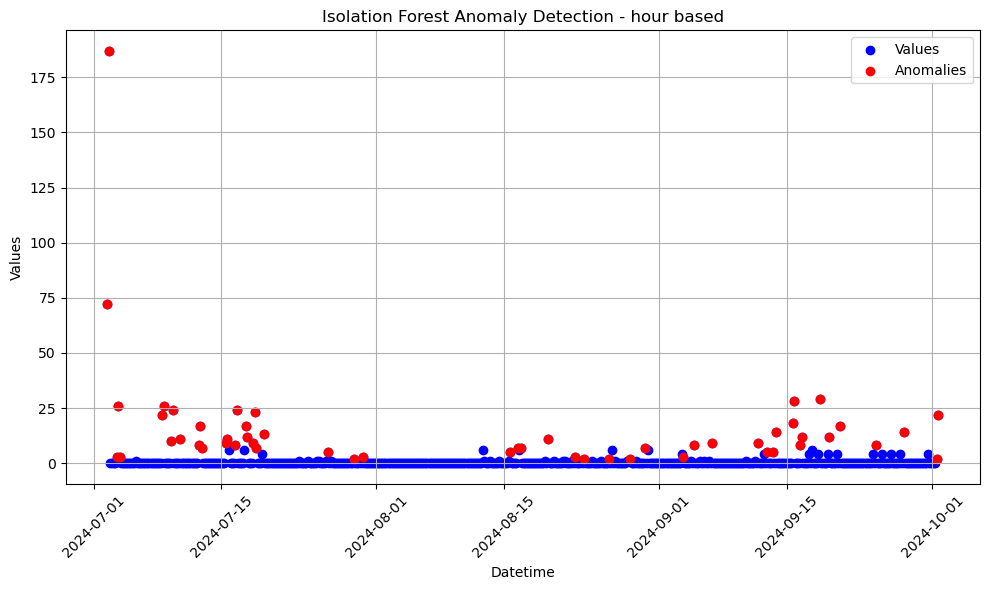

Total anomalies: 53, Percentage of anomalous values: 9.67153284671533%
               datetime  state  anomaly
19  2024-07-05 16:00:00    1.0        1
80  2024-07-15 20:00:00    6.0        1
90  2024-07-17 12:00:00    6.0        1
102 2024-07-19 12:00:00    4.0        1
126 2024-07-23 12:00:00    1.0        1
132 2024-07-24 12:00:00    1.0        1
138 2024-07-25 12:00:00    1.0        1
139 2024-07-25 16:00:00    1.0        1
144 2024-07-26 12:00:00    1.0        1
147 2024-07-27 00:00:00    1.0        1
166 2024-07-30 04:00:00    1.0        1
247 2024-08-12 16:00:00    6.0        1
248 2024-08-12 20:00:00    1.0        1
252 2024-08-13 12:00:00    1.0        1
258 2024-08-14 12:00:00    1.0        1
264 2024-08-15 12:00:00    1.0        1
271 2024-08-16 16:00:00    6.0        1
288 2024-08-19 12:00:00    1.0        1
294 2024-08-20 12:00:00    1.0        1
300 2024-08-21 12:00:00    1.0        1
301 2024-08-21 16:00:00    1.0        1
306 2024-08-22 12:00:00    1.0        1
312 2024-

In [98]:
from sklearn.ensemble import IsolationForest

# office_hourly['datetime'] = pd.to_datetime(office_hourly['datetime'])

# Prepare data for IsolationForest
values = office_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination=0.1, random_state=42)
office_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = office_hourly[office_hourly['anomaly'] == -1]
non_anomalies = office_hourly[office_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('Isolation Forest Anomaly Detection - hour based')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

count_anomaly_h = (office_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(office_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

df_filtered.to_csv('regular_office.csv', index=False)
anomalies.to_csv('anomaly_office.csv', index=False)

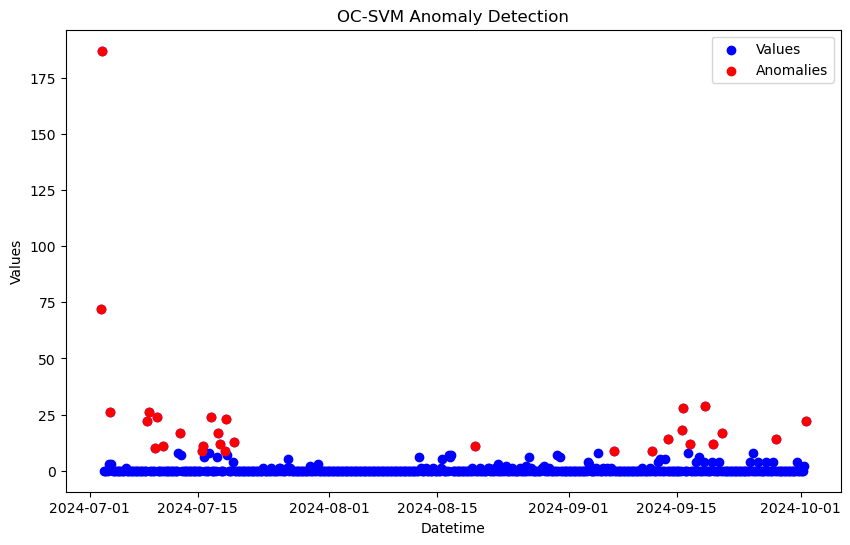

Total anomalies: 29, Percentage of anomalous values: 5.291970802919708%
               datetime  state  anomaly  scaled_states
6   2024-07-03 12:00:00    3.0        1       0.135264
8   2024-07-03 20:00:00    3.0        1       0.135264
19  2024-07-05 16:00:00    1.0        1      -0.077738
60  2024-07-12 12:00:00    8.0        1       0.667769
62  2024-07-12 20:00:00    7.0        1       0.561268
..                  ...    ...      ...            ...
510 2024-09-25 12:00:00    4.0        1       0.241765
516 2024-09-26 12:00:00    4.0        1       0.241765
522 2024-09-27 12:00:00    4.0        1       0.241765
540 2024-09-30 12:00:00    4.0        1       0.241765
546 2024-10-01 12:00:00    2.0        1       0.028763

[73 rows x 4 columns]
               datetime  state  anomaly  scaled_states
2   2024-07-02 20:00:00    0.0        1      -0.184239
3   2024-07-03 00:00:00    0.0        1      -0.184239
4   2024-07-03 04:00:00    0.0        1      -0.184239
5   2024-07-03 08:00:00  

In [99]:
# using ocsvm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

scaler = StandardScaler()  # OC-SVM benefits from scaling the data
office_hourly['scaled_states'] = scaler.fit_transform(office_hourly[['state']])

# Train OC-SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu=0.05 means 5% anomalies expected
office_hourly['anomaly'] = ocsvm.fit_predict(office_hourly[['scaled_states']])

# In OC-SVM, -1 indicates an anomaly, and 1 indicates normal data
anomalies = office_hourly[office_hourly['anomaly'] == -1]
non_anomalies = office_hourly[office_hourly['anomaly'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], label='Values', color='blue')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.title('OC-SVM Anomaly Detection')
plt.legend()
plt.show()

count_anomaly_h = (office_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(office_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

non_anomalies.to_csv('regular_office_svm.csv', index=False)
anomalies.to_csv('anomaly_office_svm.csv', index=False)